In [23]:
import os
import numpy as np
import pytesseract
import cv2
import matplotlib.pyplot as plt
import json
from utils import show, convert,  add_location, preprocessing
# debug 
isDebugMode = True

def read_templates(directory_path):
    templates = []
    files = []
    
    for f in os.listdir(directory_path):
        if f.lower().endswith(('.png', '.jpg', '.jpeg')):
            # 템플릿 이미지를 그레이스케일로 읽어오기
            template = cv2.imread(os.path.join(directory_path, f))
            # 이진화 수행
            template_threshold = preprocessing(template)   

            # 이진화된 이미지를 템플릿 리스트에 추가
            templates.append(template_threshold)

            name, ext = os.path.splitext(f)
            files.append(name)
    
    return templates, files
def debug(msg):
    if isDebugMode:
        print(msg)

def debugShow(template):
    if isDebugMode:
        show(template)

# 디렉토리 경로
directory_path = "template_img/"
templates, files = read_templates(directory_path)

# 실행파일 위치저장
pytesseract.pytesseract.tesseract_cmd = "C:/Tesseract-OCR/tesseract.exe"

class OCR:
    def __init__(self):
        pass
 
    def get(self, img, mode):
        
        debugShow(img)
        # 전처리 
        if mode == 'kor':
            roi_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            _, roi = cv2.threshold(roi_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            
        elif mode == 'number':
            roi_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            _, roi = cv2.threshold(roi_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        elif mode == 'eng':
            roi_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            roi = roi_gray
       
        elif mode == 'img':
            roi_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            _, roi = cv2.threshold(roi_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            
        # debugShow(roi)
        # 이미지 스캔          
        if mode == 'kor':
            text = pytesseract.image_to_string(roi, lang='kor+eng --psm 6')
            return text
        elif mode == 'number':
            text = ''.join(filter(str.isdigit, pytesseract.image_to_string(roi, config='--psm 6')))
            return text
        elif mode == 'eng':
            text = ''.join(filter(str.isalpha, pytesseract.image_to_string(roi, config='eng --oem')))
            return text     
        elif mode == 'img':
            text = pytesseract.image_to_string(roi, lang='kor+eng --psm 6')
            return text
        else:
            return "Invalid language type"
 


In [24]:
# 클래스 인스턴스 생성
ocr = OCR()

# 위치 정보를 추가
locationInfos = []
add_location(locationInfos, 'no', 292, 163, 330, 185, 'number')
add_location(locationInfos, 'command', 356, 168, 1250, 210, 'kor')
add_location(locationInfos, 'name', 348, 135, 604, 169, 'eng')
add_location(locationInfos, 'command', 356, 168, 1250, 210, 'searchTemplate') 


이미지 raven1.jpg 을 찾을 수 없습니다.


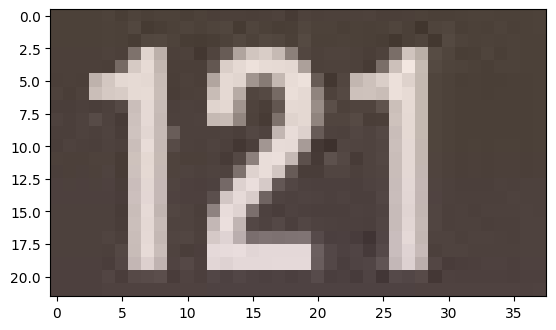

{'number': '121'}


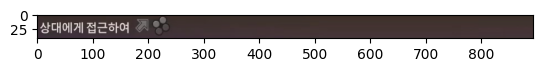

{'kor': '상대에게 접근하여\n'}


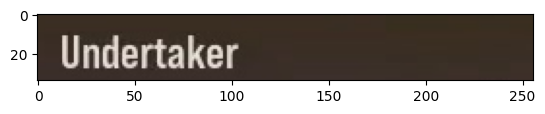

{'eng': 'Undertaker'}


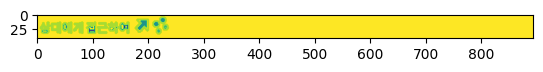

템플릿 0 ak  0.5875803232192993
템플릿 1 ap  0.9333458542823792


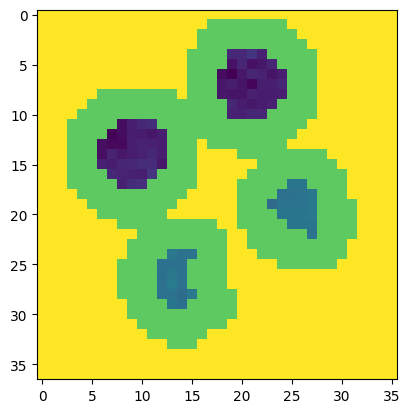

founded list : ap 2개
템플릿 2 apk  0.8514221906661987
템플릿 3 arrow_2  0.5443946123123169
템플릿 4 arrow_3  0.6104975938796997
템플릿 5 arrow_3bold  0.3150165379047394
템플릿 6 arrow_4  0.5549375414848328
템플릿 7 arrow_4bold  0.2835695445537567
템플릿 8 arrow_6  0.5260822176933289
템플릿 9 arrow_6bold  0.28604453802108765
템플릿 10 arrow_7  0.5959620475769043
템플릿 11 arrow_9  0.9822148084640503


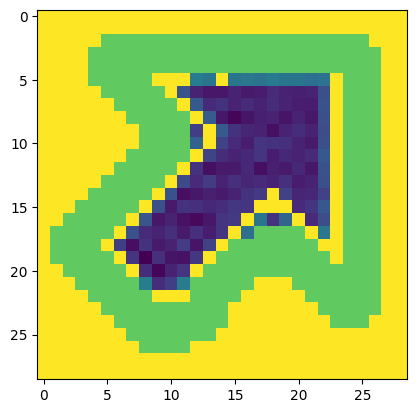

founded list : arrow_9 1개
템플릿 12 bracketL  0.3324168026447296
템플릿 13 bracketR  0.3467908799648285
템플릿 14 bracketRoundL  0.5472210049629211
템플릿 15 bracketRoundR  0.5450100898742676
템플릿 16 lk  0.6594074964523315
템플릿 17 lp  0.8440542817115784
템플릿 18 rk  0.6926153898239136
템플릿 19 rp  0.852759838104248
[{'x': 175, 'y': 6, 'ratio': '0.982215', 'command': 'arrow_9'}, {'x': 205, 'y': 3, 'ratio': '0.933346', 'command': 'ap'}, {'x': 206, 'y': 3, 'ratio': '0.906596', 'command': 'ap'}]
{'x': 175, 'y': 6, 'ratio': '0.982215', 'command': 'arrow_9'}
{'x': 205, 'y': 3, 'ratio': '0.933346', 'command': 'ap'}
{'x': 206, 'y': 3, 'ratio': '0.906596', 'command': 'ap'}
{'kor': '상대에게 접근하여\n', 'searchTemplate': [{'x': 175, 'y': 6, 'ratio': '0.982215', 'command': 'arrow_9'}, {'x': 205, 'y': 3, 'ratio': '0.933346', 'command': 'ap'}, {'x': 206, 'y': 3, 'ratio': '0.906596', 'command': 'ap'}]}
이미지 raven3.jpg 을 찾을 수 없습니다.


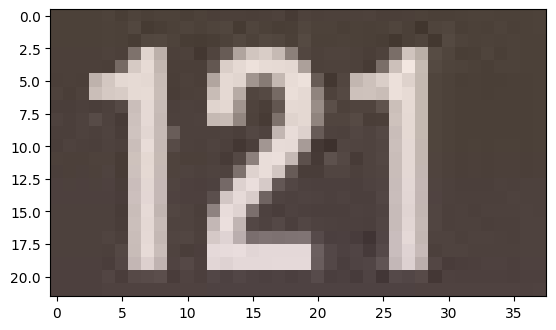

{'number': '121'}


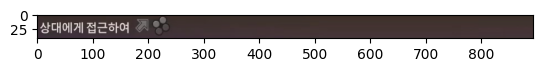

{'kor': '상대에게 접근하여\n'}


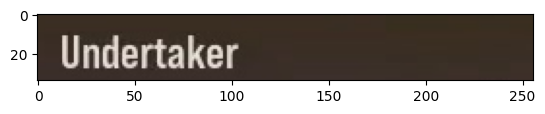

{'eng': 'Undertaker'}


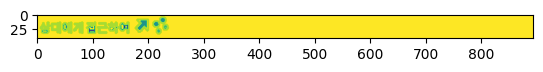

템플릿 0 ak  0.5875803232192993
템플릿 1 ap  0.9333458542823792


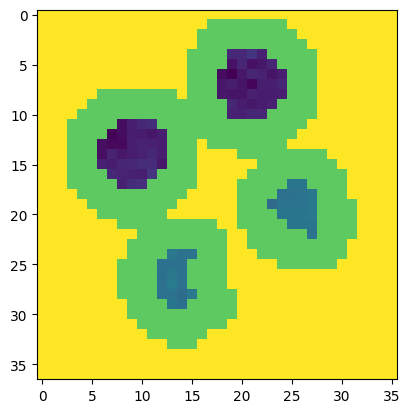

founded list : ap 2개
템플릿 2 apk  0.8514221906661987
템플릿 3 arrow_2  0.5443946123123169
템플릿 4 arrow_3  0.6104975938796997
템플릿 5 arrow_3bold  0.3150165379047394
템플릿 6 arrow_4  0.5549375414848328
템플릿 7 arrow_4bold  0.2835695445537567
템플릿 8 arrow_6  0.5260822176933289
템플릿 9 arrow_6bold  0.28604453802108765
템플릿 10 arrow_7  0.5959620475769043
템플릿 11 arrow_9  0.9822148084640503


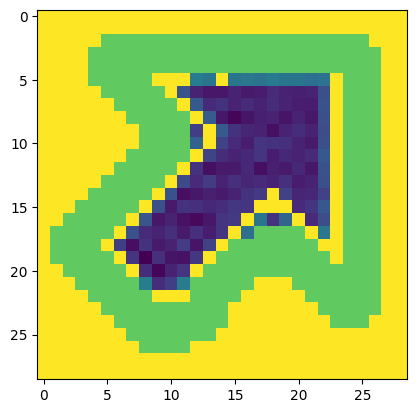

founded list : arrow_9 1개
템플릿 12 bracketL  0.3324168026447296
템플릿 13 bracketR  0.3467908799648285
템플릿 14 bracketRoundL  0.5472210049629211
템플릿 15 bracketRoundR  0.5450100898742676
템플릿 16 lk  0.6594074964523315
템플릿 17 lp  0.8440542817115784
템플릿 18 rk  0.6926153898239136
템플릿 19 rp  0.852759838104248
[{'x': 175, 'y': 6, 'ratio': '0.982215', 'command': 'arrow_9'}, {'x': 205, 'y': 3, 'ratio': '0.933346', 'command': 'ap'}, {'x': 206, 'y': 3, 'ratio': '0.906596', 'command': 'ap'}]
{'x': 175, 'y': 6, 'ratio': '0.982215', 'command': 'arrow_9'}
{'x': 205, 'y': 3, 'ratio': '0.933346', 'command': 'ap'}
{'x': 206, 'y': 3, 'ratio': '0.906596', 'command': 'ap'}
{'kor': '상대에게 접근하여\n', 'searchTemplate': [{'x': 175, 'y': 6, 'ratio': '0.982215', 'command': 'arrow_9'}, {'x': 205, 'y': 3, 'ratio': '0.933346', 'command': 'ap'}, {'x': 206, 'y': 3, 'ratio': '0.906596', 'command': 'ap'}]}


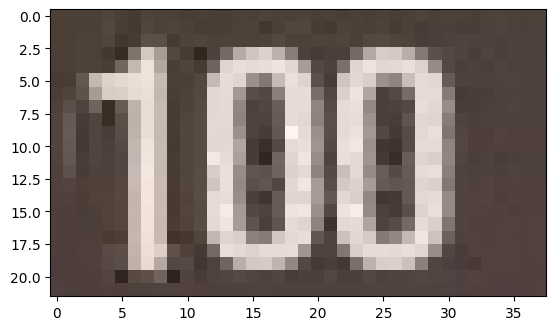

{'number': '100'}


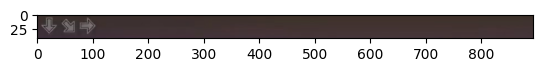

{'kor': '열다\n'}


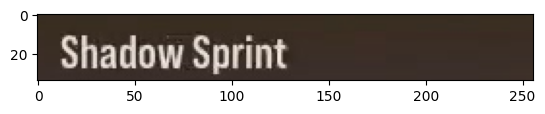

{'eng': 'ShadowSprint'}


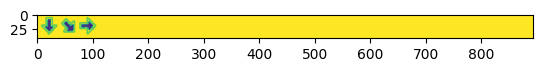

템플릿 0 ak  0.42371970415115356
템플릿 1 ap  0.4186900556087494
템플릿 2 apk  0.3853040039539337
템플릿 3 arrow_2  0.9169641733169556


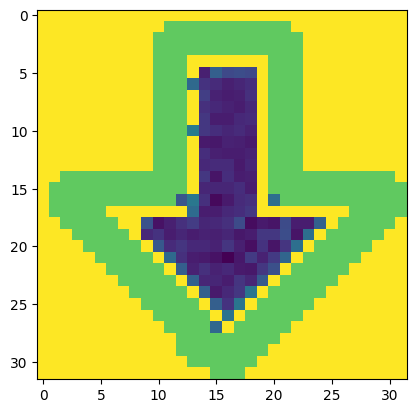

founded list : arrow_2 1개
템플릿 4 arrow_3  0.8935346007347107
템플릿 5 arrow_3bold  0.20776082575321198
템플릿 6 arrow_4  0.6642501950263977
템플릿 7 arrow_4bold  0.28561413288116455
템플릿 8 arrow_6  0.9436238408088684


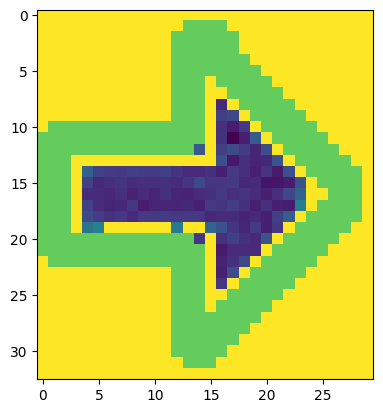

founded list : arrow_6 1개
템플릿 9 arrow_6bold  0.2700659930706024
템플릿 10 arrow_7  0.6752142310142517
템플릿 11 arrow_9  0.5890626311302185
템플릿 12 bracketL  0.428935170173645
템플릿 13 bracketR  0.5070732235908508
템플릿 14 bracketRoundL  0.534339964389801
템플릿 15 bracketRoundR  0.5840842127799988
템플릿 16 lk  0.4873757064342499
템플릿 17 lp  0.46228963136672974
템플릿 18 rk  0.47095057368278503
템플릿 19 rp  0.43633896112442017
[{'x': 6, 'y': 4, 'ratio': '0.916964', 'command': 'arrow_2'}, {'x': 77, 'y': 4, 'ratio': '0.943624', 'command': 'arrow_6'}]
{'x': 6, 'y': 4, 'ratio': '0.916964', 'command': 'arrow_2'}
{'x': 77, 'y': 4, 'ratio': '0.943624', 'command': 'arrow_6'}
{'kor': '열다\n', 'searchTemplate': [{'x': 6, 'y': 4, 'ratio': '0.916964', 'command': 'arrow_2'}, {'x': 77, 'y': 4, 'ratio': '0.943624', 'command': 'arrow_6'}]}


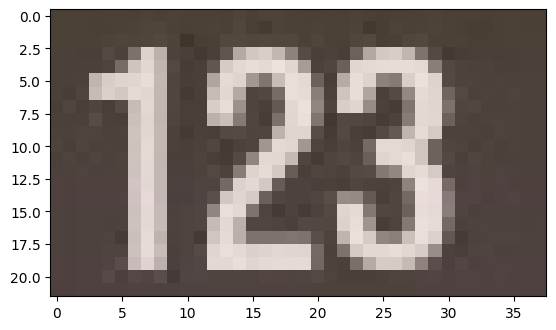

{'number': '123'}


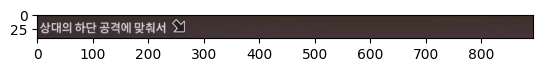

{'kor': '에 맞춰서 1\n'}


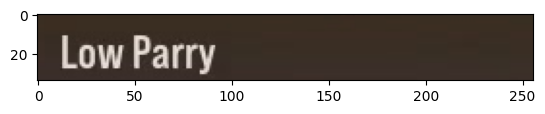

{'eng': 'LowParry'}


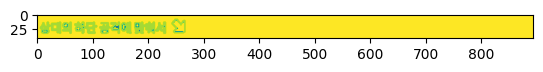

템플릿 0 ak  0.4365006685256958
템플릿 1 ap  0.3433821201324463
템플릿 2 apk  0.35325226187705994
템플릿 3 arrow_2  0.47432100772857666
템플릿 4 arrow_3  0.4473019540309906
템플릿 5 arrow_3bold  0.67169588804245
템플릿 6 arrow_4  0.4721222519874573
템플릿 7 arrow_4bold  0.33301156759262085
템플릿 8 arrow_6  0.5445775389671326
템플릿 9 arrow_6bold  0.33260390162467957
템플릿 10 arrow_7  0.5462139844894409
템플릿 11 arrow_9  0.453888863325119
템플릿 12 bracketL  0.3289735019207001
템플릿 13 bracketR  0.35824865102767944
템플릿 14 bracketRoundL  0.5892983078956604
템플릿 15 bracketRoundR  0.5696965456008911
템플릿 16 lk  0.4360240399837494
템플릿 17 lp  0.45842912793159485
템플릿 18 rk  0.3898147940635681
템플릿 19 rp  0.2614487409591675
[]
{'kor': '에 맞춰서 1\n', 'searchTemplate': []}


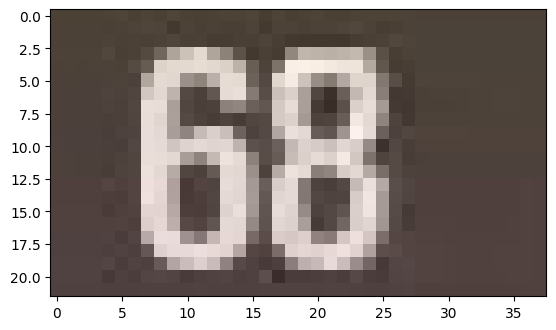

{'number': '68'}


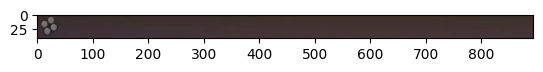

{'kor': ''}


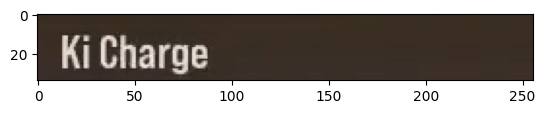

{'eng': 'KiCharge'}


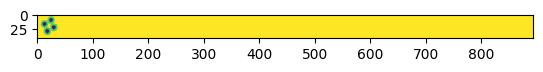

템플릿 0 ak  0.7912818193435669
템플릿 1 ap  0.8737135529518127
템플릿 2 apk  0.9867441058158875


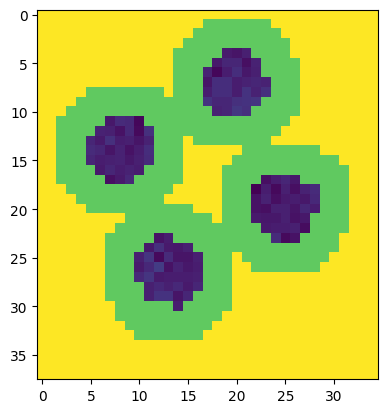

founded list : apk 1개
템플릿 3 arrow_2  0.37206506729125977
템플릿 4 arrow_3  0.3852751851081848
템플릿 5 arrow_3bold  0.276556134223938
템플릿 6 arrow_4  0.3319651484489441
템플릿 7 arrow_4bold  0.289977103471756
템플릿 8 arrow_6  0.30814528465270996
템플릿 9 arrow_6bold  0.29587724804878235
템플릿 10 arrow_7  0.5065572261810303
템플릿 11 arrow_9  0.40031713247299194
템플릿 12 bracketL  0.34104111790657043
템플릿 13 bracketR  0.3468421697616577
템플릿 14 bracketRoundL  0.3947766125202179
템플릿 15 bracketRoundR  0.37319839000701904
템플릿 16 lk  0.8244454264640808
템플릿 17 lp  0.8046033382415771
템플릿 18 rk  0.7903165221214294
템플릿 19 rp  0.7691868543624878
[{'x': 5, 'y': 3, 'ratio': '0.986744', 'command': 'apk'}]
{'x': 5, 'y': 3, 'ratio': '0.986744', 'command': 'apk'}
{'kor': '', 'searchTemplate': [{'x': 5, 'y': 3, 'ratio': '0.986744', 'command': 'apk'}]}


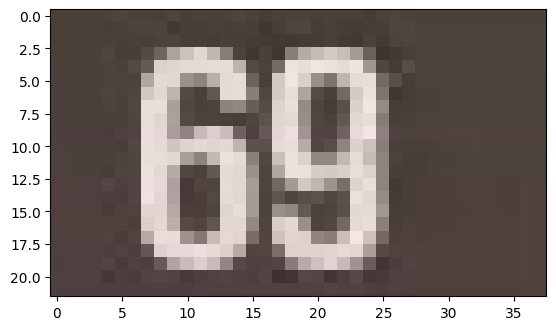

{'number': '69'}


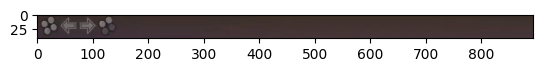

{'kor': '로 리\n'}


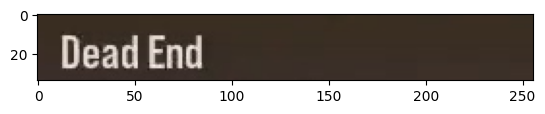

{'eng': 'DeadEnd'}


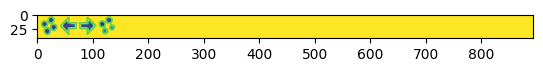

템플릿 0 ak  0.7874816656112671
템플릿 1 ap  0.9169819355010986


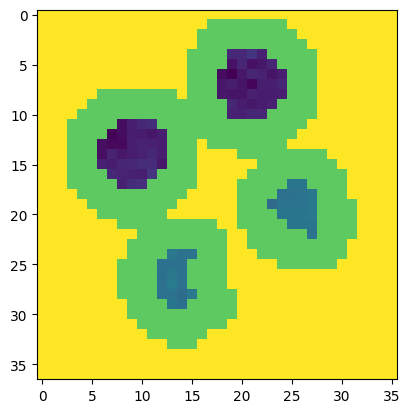

founded list : ap 1개
템플릿 2 apk  0.9736404418945312


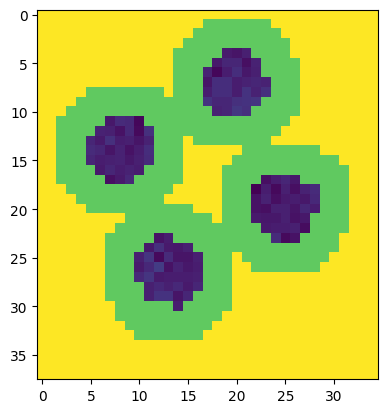

founded list : apk 1개
템플릿 3 arrow_2  0.6278901696205139
템플릿 4 arrow_3  0.5247082114219666
템플릿 5 arrow_3bold  0.32409363985061646
템플릿 6 arrow_4  0.9915933012962341


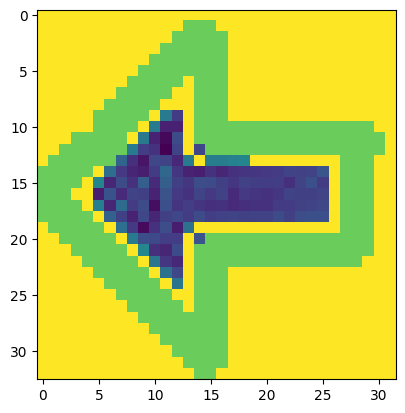

founded list : arrow_4 1개
템플릿 7 arrow_4bold  0.298936665058136
템플릿 8 arrow_6  0.9569573402404785


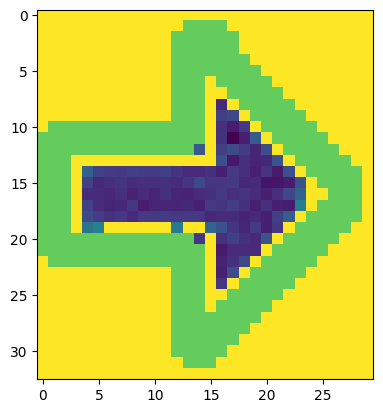

founded list : arrow_6 1개
템플릿 9 arrow_6bold  0.288431853055954
템플릿 10 arrow_7  0.5083205103874207
템플릿 11 arrow_9  0.531574547290802
템플릿 12 bracketL  0.34322452545166016
템플릿 13 bracketR  0.3606977164745331
템플릿 14 bracketRoundL  0.419521689414978
템플릿 15 bracketRoundR  0.423276424407959
템플릿 16 lk  0.8187888860702515
템플릿 17 lp  0.8096135258674622
템플릿 18 rk  0.7959191799163818
템플릿 19 rp  0.8679867386817932
[{'x': 5, 'y': 3, 'ratio': '0.973640', 'command': 'apk'}, {'x': 42, 'y': 4, 'ratio': '0.991593', 'command': 'arrow_4'}, {'x': 77, 'y': 4, 'ratio': '0.956957', 'command': 'arrow_6'}, {'x': 108, 'y': 3, 'ratio': '0.916982', 'command': 'ap'}]
{'x': 5, 'y': 3, 'ratio': '0.973640', 'command': 'apk'}
{'x': 42, 'y': 4, 'ratio': '0.991593', 'command': 'arrow_4'}
{'x': 77, 'y': 4, 'ratio': '0.956957', 'command': 'arrow_6'}
{'x': 108, 'y': 3, 'ratio': '0.916982', 'command': 'ap'}
{'kor': '로 리\n', 'searchTemplate': [{'x': 5, 'y': 3, 'ratio': '0.973640', 'command': 'apk'}, {'x': 42, 'y': 4, 'ratio': 

In [25]:
## 메인 함수
def main(img_name): 

    # 이미지 읽기
    img = cv2.imread(img_name)

    # 이미지 있는지 체크 하고 없으면 그다음 이미지로 넘어감
    if img is None:
        print(f"이미지 {img_name} 을 찾을 수 없습니다.")
        return
    
    # 이미지 크기 확인
    # height, width, _ = img.shape

    # 결과값 dict
    results = {}



    # 위치 배열을 순회하며 이미지에서 자르고 텍스트 읽어오기
    for locationIndex, locationInfo in enumerate(locationInfos):
        name, mode = locationInfo['name'], locationInfo['mode']
        # 이미지에서 특정 구간 자르기 
        img_roi = img[locationInfo['y1']:locationInfo['y2'], locationInfo['x1']:locationInfo['x2']]
        
        item = results.get(name, {})
        
        if mode != 'searchTemplate':
            item[mode] = ocr.get(img_roi, mode) # OCR 실행    
            
        if mode == 'searchTemplate':

            roi_threshold = preprocessing(img_roi) 
            debugShow(roi_threshold)
            
            # B1 템플릿 매칭 수행
            found_locations = []
            # debug("----------------------------------")
            for tidx, template in enumerate(templates):   
                
                # B1-1 템플릿 매칭 수행, 유사도 N% 이상인 위치 찾기
                result = cv2.matchTemplate(roi_threshold, template, cv2.TM_CCOEFF_NORMED)
                ratio = 0.90 
                matched = np.where(result >= ratio) 
    
                debug(f"템플릿 {tidx} {files[tidx]}  {result.max()}") # 최대 유사도 출력
                if len(matched[0]) > 0:
                    if( isDebugMode ) :
                        debugShow(template)
                        debug(f"founded list : {files[tidx]} {len(matched[0])}개")
                    # 찾은 위치와 유사도를 함께 저장
                    for pt in zip(*matched[::-1]):
                        data = { 'x': pt[0], 'y': pt[1], 'ratio': "{:.6f}".format(result[pt[1], pt[0]]), name: files[tidx] } 
                        found_locations.append(data)  
                        # debug(f">  {data}")
                
                # debug("----------------------------------")

            # 정렬 배열에 x 순서대로
            found_locations = sorted(found_locations, key=lambda x: x['x'])
            debug(found_locations)
            if( isDebugMode ) :
                # 결과 이미지에 템플릿 위치 표시
                for found_location in found_locations:
                    print(found_location) 
                    h, w = template.shape 
                    x, y  = found_location['x'], found_location['y']
                    top_left = (x, y)
                    bottom_right = (x + w, y + h)
                    cv2.rectangle(img_roi, top_left, bottom_right, 255, 2)
            
            item[mode] = found_locations
        
        # 결과값 저장   
        print(item)
        results[name] = item
        
    # 결과값 출력 
    # print('결과')
    # print(results)
    # print(json.dumps(results,default=convert, indent=4, ensure_ascii=False))
 
    return results
                


    
# 이미지 배열
img_names = ["raven1.jpg", "raven2.jpg", "raven3.jpg", "raven4.jpg", "raven5.jpg", "raven6.jpg", "raven7.jpg", "raven8.jpg"]

res = []
# 이미지 순회 main() 함수 실행
for img_name in img_names:
    res.append(main(img_name))

filename = 'raven.json'
with open(filename, 'w', encoding='utf-8') as make_file:
    json.dump(res, make_file, default=convert,  ensure_ascii=False, indent="\t")
